In [12]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##Exploration

In [13]:
from datasets import load_dataset
import torch
from tqdm import tqdm

wiki = load_dataset("wikitext", "wikitext-2-raw-v1")

train = wiki['train']['text']
test = wiki['test']['text']
val = wiki['validation']['text']

**DATA PREDICTION**

C:\Users\xiao\AppData\Local\Temp\ipykernel_6660\785700428.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

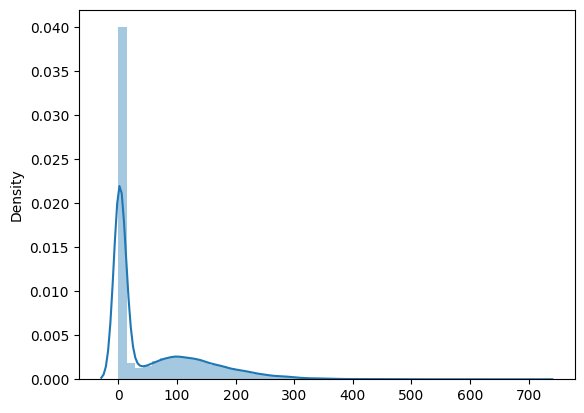

In [14]:
doc_lengths = []

for doc in train:

    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

C:\Users\xiao\AppData\Local\Temp\ipykernel_6660\2040143835.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

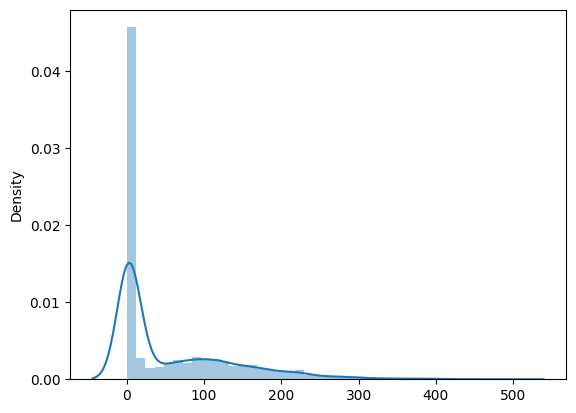

In [15]:
#test
doc_lengths = []

for doc in test:

    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

C:\Users\xiao\AppData\Local\Temp\ipykernel_6660\3595688186.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

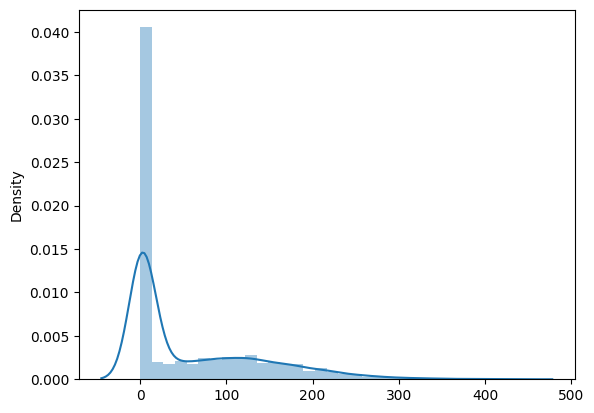

In [16]:
#val
doc_lengths = []

for doc in val:

    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [17]:
len(doc_lengths[doc_lengths > 100])/len(doc_lengths)

0.26941489361702126

#Data preprocess

In [18]:
import re
def PreprocessTitle(dataset):
    filter_set = list(filter(lambda element: element != '', dataset))
    title_position = 0
    dealt_set = []
    title_content = ""
    for i,j in enumerate(filter_set):
        pattern_s = re.compile(r'@\W@')
        s_flag = pattern_s.search(j)
        if s_flag:
          filter_set[i] = re.sub(r' @(\W)@ ',r'\1',filter_set[i])
        pattern = re.compile(r'^ = .+ = \n$')
        result = pattern.match(j)
        if result:
            final_string = ""
            for k in range(title_position,i):
                if k == title_position:
                    pattern2 = re.compile(r'^ = = .+ = = \n$')
                    result2 = pattern2.match(filter_set[k])
                    if result2:
                        temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        temp = re.sub(r'\n$', ':', temp)
                        # If necessary, remove all the = in the titles
                        # temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        # temp = re.sub(r'\n$', '', temp)
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                    else:
                        # Seperating the title and the content with a colon
                        temp = re.sub(r'\n$', ':', filter_set[k])
                        title_content = re.sub(r'^ = ', ' ', temp)
                        title_content = re.sub(r' = :$', ' : ', title_content)
                        # If necessary, remove all the = in the titles
                        # temp = re.sub(r'\n$', '', filter_set[k])
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                        # title_content = temp
                        # temp = re.sub(r': $', ':', temp)
                    final_string = final_string + temp
                else:
                    temp = re.sub(r'\n$', '', filter_set[k]) 
                    final_string = final_string + temp
            pattern_empty = re.compile(r':$')
            flag = pattern_empty.search(final_string)
            if flag:
              pass
            else:
              dealt_set.append(final_string)
            title_position = i

    dealt_set = [s for s in dealt_set if s.strip() != ""] 
    return dealt_set

In [19]:
dealt_train = PreprocessTitle(train)
dealt_test = PreprocessTitle(test)
dealt_val = PreprocessTitle(val)
for i in dealt_train[:25]:
  print(i[:100])

 = Valkyria Chronicles III = : Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 
 = = Valkyria Chronicles III : Gameplay = = : As with previous Valkyira Chronicles games , Valkyria 
 = = Valkyria Chronicles III : Plot = = : The game takes place during the Second Europan War . Galli
 = = Valkyria Chronicles III : Development = = : Concept work for Valkyria Chronicles III began afte
 = = = Valkyria Chronicles III : Music = = = : The music was composed by Hitoshi Sakimoto , who had 
 = = = Valkyria Chronicles III : Release = = = : In September 2010 , a teaser website was revealed b
 = = Valkyria Chronicles III : Reception = = : On its day of release in Japan , Valkyria Chronicles 
 = = Valkyria Chronicles III : Legacy = = : Kurt and Riela were featured in the Nintendo 3DS crossov
 = = = Valkyria Chronicles III : Adaptations = = = : Valkyria Chronicles 3 was adapted into a two-ep
 = Tower Building of the Little Rock Arsenal = : The Tower Building of the Little Rock Arse

**DATA CHECK AFTER PROCESS**

C:\Users\xiao\AppData\Local\Temp\ipykernel_6660\3385743972.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

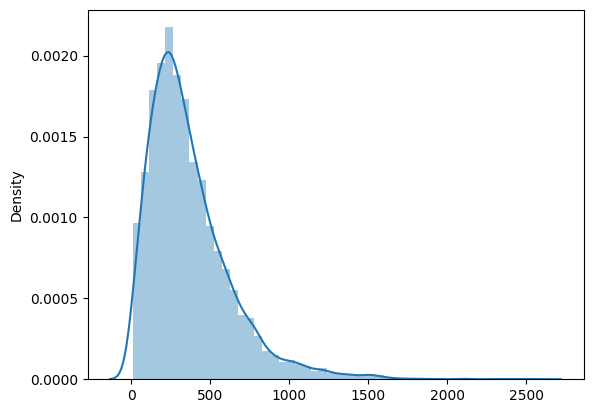

In [20]:
doc_lengths = []

for doc in dealt_train:

    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

C:\Users\xiao\AppData\Local\Temp\ipykernel_6660\3640349026.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

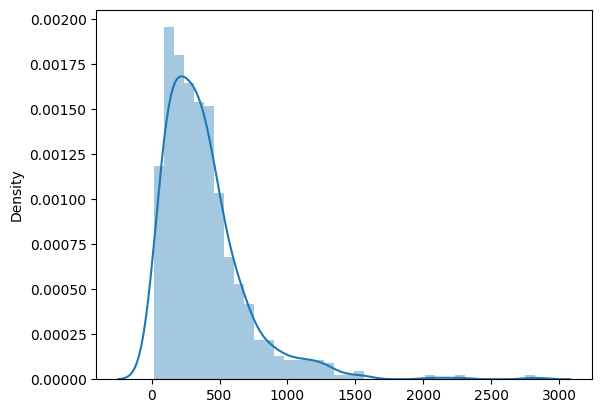

In [21]:
#test
doc_lengths = []

for doc in dealt_test:

    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

C:\Users\xiao\AppData\Local\Temp\ipykernel_6660\2345381441.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

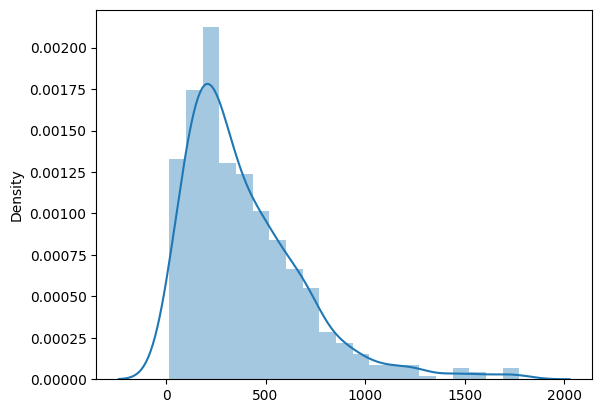

In [22]:
#val
doc_lengths = []

for doc in dealt_val:

    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [24]:

import json

with open("./data/train.json", "w") as json_file:
    json.dump(dealt_train, json_file)
with open("./data/test.json", "w") as json_file:
    json.dump(dealt_test, json_file)
with open("./data/val.json", "w") as json_file:
    json.dump(dealt_val, json_file)

**Conclusion**

So we decided to let the max_length be 500 to save the RAM for model training. Or it will be extremely slow that we can't afford it for this final project